In [3]:
!pip install tensorflow

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/376.0 MB 4.2 MB/s eta 0:01:31
   ---------------------------------------- 1.3/376.0 MB 4.2 MB/s eta 0:01:30
   ---------------------------------------- 1.8/376.0 MB 3.6 MB/s eta 0:01:45
   ---------------------------------------- 3.1/376.0 MB 4.0 MB/s eta 0:01:33
    --------------------------------------- 4.7/376.0 MB 4.8 MB/s eta 0:01:19
    --------------------------------------- 6.0/376.0 MB 5.1 MB/s eta 0:01:14
    --------------------------------------- 6.8/376.0 MB 5.1 MB/s eta 0:01:14
    --------------------------------------- 7.9/376.0 MB 5.0 MB/s eta 0:01:14
    --------------------------------------- 8.1/376.0 MB 4.5 MB/s eta 0:01:23
    --------------------------------------- 8.7/376.0 MB 4.3 MB/s eta 0:01:27
    --------------------------------------- 9.2/376.0 MB 4.1 MB/s eta 0:01:30
   - -------------------------------------- 9.7/376.0 MB 4.0 MB/s eta 0

In [5]:
!pip install gensim

In [42]:
#!pip install fasttext --quiet
#!pip install demoji --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string
import warnings
import demoji
import nltk
from gensim.models.fasttext import FastText
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")
nltk.download("stopwords")
demoji.download_codes()

STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don',
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 'de', 're', 'amp', 'will', 'wa', 'e', 'like'])
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oyewa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
df = pd.read_csv('cyberbullying_tweets.csv')  
df.head(-1)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47686,@YourFavWhiteGuy shut the fuck upAbout your du...,ethnicity
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity


Quick Data Check

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


Data Preprocessing

In [52]:
def clean_text(text):
    # Remove Hashtags, Mentions, URLs
    text = re.sub(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+)", '', text)
    text = text.lower()
    text = " ".join([stemmer.stem(word) for word in text.split()])
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    
    emojis = demoji.findall(text)
    for emot in emojis:
        text = text.replace(emot, "_".join(emojis[emot].split()))
    
    return text.strip()

df['cleaned_text'] = df['tweet_text'].astype(str).apply(clean_text)
df.drop_duplicates(subset='cleaned_text', inplace=True)
df = df[df["cyberbullying_type"] != "other_cyberbullying"]
df.loc[df["cyberbullying_type"] == "not_cyberbullying", "cyberbullying_type"] = "not_CB"
df.reset_index(drop=True, inplace=True)

In [54]:
df.head()

,tweet_text,cyberbullying_type,cleaned_text
0,"In other words #katandandre, your food was cra...",not_CB,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_CB,whi white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_CB,classi whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_CB,gio meh thank head concern anoth angri dude tw...
4,@RudhoeEnglish This is an ISIS account pretend...,not_CB,isi account pretend kurdish account islam lies


In [58]:
df.isnull().sum() # Checking for missing values

tweet_text            0
cyberbullying_type    0
cleaned_text          0
dtype: int64

In [60]:
df['cleaned_text'].duplicated().sum() # Checking for duplicate values

0

In [62]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion     7946
age          7887
ethnicity    7780
not_CB       7632
gender       7578
Name: count, dtype: int64

<Axes: xlabel='cyberbullying_type', ylabel='count'>

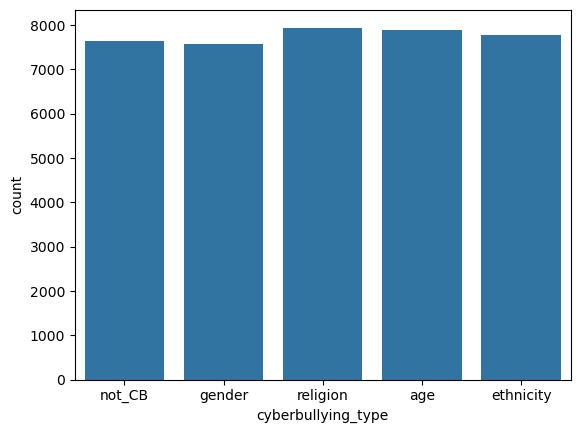

In [64]:
sns.countplot(data = df, x = 'cyberbullying_type')

Prepare for Modeling

In [14]:
X = df['cleaned_text']
y = df['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# One-hot encode for classification
y_train_cat = tf.keras.utils.to_categorical(y_train_enc)
y_test_cat = tf.keras.utils.to_categorical(y_test_enc)


Tokenize and Pad Text

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = max([len(x) for x in X_train_seq])

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [19]:
# Tokenize X_train into word lists (for FastText training)
tokenized_sentences = [text.split() for text in X_train]

# Train FastText model using gensim
fasttext_model = FastText(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Build the embedding matrix using FastText vectors
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))  # +1 for padding token

for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Optional fallback

Define and Train Model

In [24]:
def create_model(vocab_size, embedding_dim, maxlen, embedding_matrix):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size + 1,
                                  output_dim=embedding_dim,
                                  input_length=maxlen,
                                  weights=[embedding_matrix],
                                  trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(y_train_cat.shape[1], activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
                  metrics=['accuracy'])
    
    # Explicitly build the model
    model.build(input_shape=(None, maxlen))

    return model

# Create and summarize the model
model = create_model(vocab_size, embedding_dim, maxlen, embedding_matrix)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 158, 100)            │       3,713,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 158, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 158, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 158, 64)             │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,521 (14.65 MB)

 Trainable params: 126,821 (495.39 KB)

 Non-trainable params: 3,713,700 (14.17 MB)

In [26]:
# Define early stopping to prevent overfitting
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [28]:
# Train the model with early stopping and validation split
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    validation_split=0.1,
    batch_size=64,
    callbacks=[es_callback],
    verbose=1
)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 93s 194ms/step - accuracy: 0.7485 - loss: 0.7345 - val_accuracy: 0.8780 - val_loss: 0.3642
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 80s 184ms/step - accuracy: 0.8827 - loss: 0.3542 - val_accuracy: 0.9092 - val_loss: 0.2541
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.9000 - loss: 0.3030 - val_accuracy: 0.9163 - val_loss: 0.2374
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 92s 210ms/step - accuracy: 0.9125 - loss: 0.2680 - val_accuracy: 0.9205 - val_loss: 0.2310
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.9151 - loss: 0.2518 - val_accuracy: 0.9166 - val_loss: 0.2335
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 94s 214ms/step - accuracy: 0.9122 - loss: 0.2572 - val_accuracy: 0.9192 - val_loss: 0.2321
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 87s 199ms/step - accuracy: 0.9183 - loss: 0.2471 - val_accuracy: 0.9202 - val_loss: 0.2229
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.9188 - loss: 0

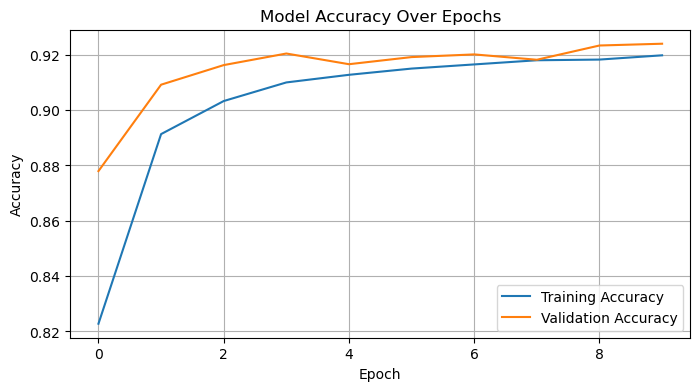

In [30]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

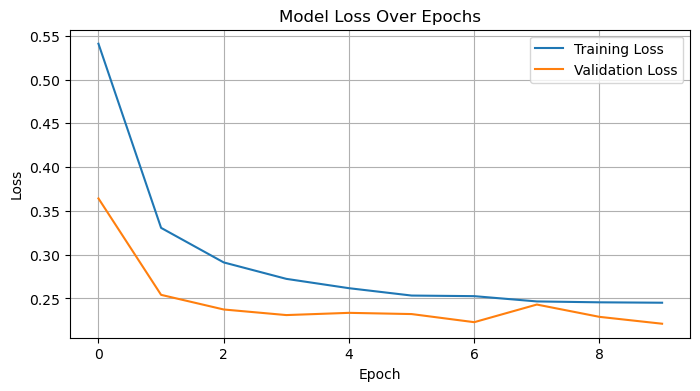

In [32]:
# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Predict on the test set
y_pred = model.predict(X_test_pad, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Print evaluation metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:

              precision    recall  f1-score   support

         age       0.98      0.97      0.98      1597
   ethnicity       0.99      0.98      0.98      1561
      gender       0.93      0.80      0.86      1513
      not_CB       0.78      0.87      0.82      1551
    religion       0.92      0.95      0.94      1543

    accuracy                           0.92      7765
   macro avg       0.92      0.92      0.92      7765
weighted avg       0.92      0.92      0.92      7765



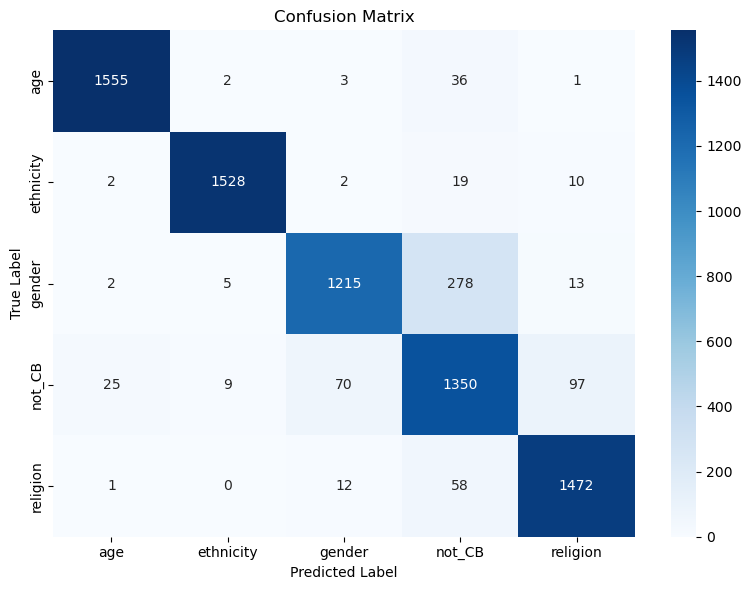

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Checking the Gender Data Missclassified as Not CB

In [68]:
# Get inverse mapping
inv_labels = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# Misclassified examples
misclassified = X_test[(y_true == label_encoder.transform(['gender'])[0]) & 
                       (y_pred_classes == label_encoder.transform(['not_CB'])[0])]
print("Misclassified gender → not_CB:\n")
misclassified.head(10)

Misclassified gender → not_CB:



13702    cunt think stop air strike hide behind captiv ...
14224                                    face pull hideous
9517                     doe legal oblig report dont think
8602                             think pink gone girl head
13730    felt place parti last night would ani man stan...
11854         karma “ god aw aw person oh humiliated good”
12474    isnt even best cook right ugh cant wait thing ...
13151    certain set much pounding hope save first go q...
15101        find kati nikki line mt druitt next top model
9936                     oh silli silli fuck thingopen eye
Name: cleaned_text, dtype: object

Downloading The Misclassified Data

In [72]:
# Create a DataFrame with misclassified examples
misclassified_df = pd.DataFrame({
    'text': X_test[(y_true == label_encoder.transform(['gender'])[0]) & 
                   (y_pred_classes == label_encoder.transform(['not_CB'])[0])],
    'true_label': 'gender',
    'predicted_label': 'not_CB'
})

# Save to CSV
misclassified_df.to_csv('misclassified_gender_to_not_CB.csv', index=False)
print("CSV file saved: misclassified_gender_to_not_CB.csv")

CSV file saved: misclassified_gender_to_not_CB.csv


Checking and Downloading Misclassified: not_CB → gender and not_CB → religion

In [76]:
# Misclassified: not_CB → gender
misclassified_cb_to_gender = pd.DataFrame({
    'text': X_test[(y_true == label_encoder.transform(['not_CB'])[0]) & 
                   (y_pred_classes == label_encoder.transform(['gender'])[0])],
    'true_label': 'not_CB',
    'predicted_label': 'gender'
})
misclassified_cb_to_gender.to_csv('misclassified_notCB_to_gender.csv', index=False)
print("Saved: misclassified_notCB_to_gender.csv")

# Misclassified: not_CB → religion
misclassified_cb_to_religion = pd.DataFrame({
    'text': X_test[(y_true == label_encoder.transform(['not_CB'])[0]) & 
                   (y_pred_classes == label_encoder.transform(['religion'])[0])],
    'true_label': 'not_CB',
    'predicted_label': 'religion'
})
misclassified_cb_to_religion.to_csv('misclassified_notCB_to_religion.csv', index=False)
print("Saved: misclassified_notCB_to_religion.csv")

Saved: misclassified_notCB_to_gender.csv
Saved: misclassified_notCB_to_religion.csv


In [80]:
# Get prediction probabilities for all test samples
y_pred_probs = y_pred 

# Get top-2 predicted class indices and their probabilities
top2_preds = np.argsort(-y_pred_probs, axis=1)[:, :2]  # Top-2 indices per row
top2_probs = np.take_along_axis(y_pred_probs, top2_preds, axis=1)  # Corresponding probs

# Create a DataFrame with full prediction analysis
df_test = pd.DataFrame({
    'text': X_test,
    'true_label': [label_encoder.classes_[i] for i in y_true],
    'predicted_label': [label_encoder.classes_[i] for i in y_pred_classes],
    'predicted_confidence': [probs[0] for probs in top2_probs],
    'second_best_label': [label_encoder.classes_[i] for i in top2_preds[:, 1]],
    'second_best_confidence': [probs[1] for probs in top2_probs],
})

# Filter for specific misclassification pairs
confused_cases = df_test[
    ((df_test['true_label'] == 'gender') & (df_test['predicted_label'] == 'not_CB')) |
    ((df_test['true_label'] == 'not_CB') & (df_test['predicted_label'] == 'gender')) |
    ((df_test['true_label'] == 'not_CB') & (df_test['predicted_label'] == 'religion'))
]

# Save to CSV
confused_cases.to_csv('misclassified_with_top2_predictions.csv', index=False)
print("Saved: misclassified_with_top2_predictions.csv")

Saved: misclassified_with_top2_predictions.csv


In [82]:
# Map cleaned text to original uncleaned tweet
clean_to_raw = df.set_index('cleaned_text')['tweet_text'].to_dict()

# Add raw tweet text column based on cleaned text in X_test
raw_texts = X_test.map(clean_to_raw)

# Get top-2 predictions and probabilities
top2_preds = np.argsort(-y_pred_probs, axis=1)[:, :2]
top2_probs = np.take_along_axis(y_pred_probs, top2_preds, axis=1)

# Build full DataFrame with raw text and predictions
df_test = pd.DataFrame({
    'raw_text': raw_texts.values,
    'cleaned_text': X_test.values,
    'true_label': [label_encoder.classes_[i] for i in y_true],
    'predicted_label': [label_encoder.classes_[i] for i in y_pred_classes],
    'predicted_confidence': [probs[0] for probs in top2_probs],
    'second_best_label': [label_encoder.classes_[i] for i in top2_preds[:, 1]],
    'second_best_confidence': [probs[1] for probs in top2_probs]
})

# Filter for key misclassification cases
confused_cases = df_test[
    ((df_test['true_label'] == 'gender') & (df_test['predicted_label'] == 'not_CB')) |
    ((df_test['true_label'] == 'not_CB') & (df_test['predicted_label'] == 'gender')) |
    ((df_test['true_label'] == 'not_CB') & (df_test['predicted_label'] == 'religion'))
]

# Save to CSV
confused_cases.to_csv('misclassified_with_raw_text_and_top2.csv', index=False)
print("Saved: misclassified_with_raw_text_and_top2.csv")

Saved: misclassified_with_raw_text_and_top2.csv


Statistical Analysis

Total Misclassified: 445
Second Best Matches True Label: 436
Percentage: 97.98%


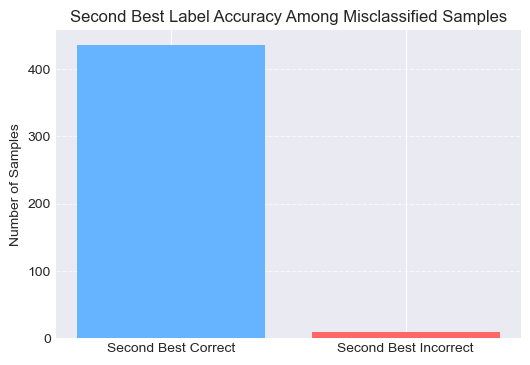

In [10]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# Load your data
file_path = 'misclassified_with_raw_text_and_top2.csv'
df = pd.read_csv(file_path)

# Find misclassified samples
misclassified = df[df['true_label'] != df['predicted_label']]

# Count how many times second_best_label matches true_label
second_best_matches = misclassified[misclassified['second_best_label'] == misclassified['true_label']]
total_misclassified = len(misclassified)
total_second_best_correct = len(second_best_matches)

# Print statistics
print(f"Total Misclassified: {total_misclassified}")
print(f"Second Best Matches True Label: {total_second_best_correct}")
print(f"Percentage: {100 * total_second_best_correct / total_misclassified:.2f}%")

# Plot the distribution with a Bar Chart
labels = ['Second Best Correct', 'Second Best Incorrect']
sizes = [total_second_best_correct, total_misclassified - total_second_best_correct]
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6, 4))
plt.bar(labels, sizes, color=colors)
plt.title("Second Best Label Accuracy Among Misclassified Samples")
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:

# Prepare data for McNemar's Test
# Contingency Table: [ [A, B], [C, D] ]
# A = Correct in both, B = Correct only in first, C = Correct only in second, D = Wrong in both

A = len(df[(df['true_label'] == df['predicted_label']) & (df['true_label'] == df['second_best_label'])])
B = len(df[(df['true_label'] == df['predicted_label']) & (df['true_label'] != df['second_best_label'])])
C = len(df[(df['true_label'] != df['predicted_label']) & (df['true_label'] == df['second_best_label'])])
D = len(df[(df['true_label'] != df['predicted_label']) & (df['true_label'] != df['second_best_label'])])

# Build the contingency table
contingency_table = [[A, B], [C, D]]

# Perform McNemar's test
result = mcnemar(contingency_table, exact=True)
print(f"McNemar's test p-value: {result.pvalue}")
if result.pvalue < 0.05:
    print("There is a significant difference in error distribution between the predicted label and second best label.")
else:
    print("No significant difference found in error distribution.")

McNemar's test p-value: 1.1270725851789228e-131
There is a significant difference in error distribution between the predicted label and second best label.
